In [1]:
from qutip import qload
from sympy.physics.secondquant import *
from sympy import symbols
import sympy as sp
from cosmatrix import expm_pade

In [318]:
import matplotlib.pyplot as plt
import scipy as sci
import autograd as ad
import autograd.numpy as np
from cosmatrix import cosm,expm_pade
expm = expm_pade
from autograd.extend import primitive, defvjp
def annihilation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),1)
def creation(dim):
    return np.diag(np.sqrt(np.arange(1,dim)),-1)
def create_custom_matrix(N, dim):
    # Initialize a dim x dim matrix with zeros
    matrix = np.zeros((2*dim+1, 2*dim+1))

    # Set the specified elements to 1
    for k in range(2*dim+1):
        if k  + N < 2*dim+1:
            matrix[k][k + N] = 1

    return matrix
def create_diagonal_matrix(dim, ng, Ec):
    # Initialize a dim x dim matrix with zeros
    matrix = np.zeros((2*dim+1, 2*dim+1))

    # Set the diagonal elements as per the given formula
    for k in range(2*dim+1):
        matrix[k][k] = 4 * Ec * ((k-dim)/N- ng)**2

    return matrix
def charge_op(dim, ng, Ec):
    # Initialize a dim x dim matrix with zeros
    matrix = np.zeros((2*dim+1, 2*dim+1))

    # Set the diagonal elements as per the given formula
    for k in range(2*dim+1):
        matrix[k][k] =   ((k-dim)/N- ng)
    return matrix
def SNAIL_charge(phi_ex,beta,N,Ej,Ec,ncut):
    ng=0
    dim = 250
    phi_ex = 2*phi_ex*np.pi
    U = beta*np.exp(1j*phi_ex)*create_custom_matrix(N, dim)+N*create_custom_matrix(1, dim)
    U = U + np.transpose(U.conjugate())
    K = 4*Ec*charge_op(dim, ng, Ec)@charge_op(dim, ng, Ec)
    H = K-Ej*U/2
    energy,U = np.linalg.eigh(H)
    U_dag = np.transpose(U.conjugate())
    energy = energy-energy[0]*np.ones(len(energy))
    charge = U_dag@charge_op(dim, ng, Ec)@U
    H = U_dag@H@U
    return (H - H[0][0]*np.identity(dim*2+1))[:ncut-1,:ncut-1],charge[:ncut-1,:ncut-1]

def SNAIL_oscillator(phi_ex,beta,N,Ej,Ec,ncut):
    sdim = 200
    phi_ex = 2*np.pi*phi_ex
    @primitive
    def Us_min(phi_ex):
        def U_s(phi): 
            return (-beta*np.cos(phi-phi_ex)-N*np.cos((phi)/N))
        phi_min = sci.optimize.minimize(U_s,0).x
        return phi_min
    
    def phi_minde(ans, phi_ex):
        def phi_minde_vjp(g):
            c2 = beta*np.cos(ans - phi_ex) + 1/N*np.cos(ans/N)
            return g*beta*np.cos(ans - phi_ex)/c2
        return phi_minde_vjp
    defvjp(Us_min, phi_minde)
    
    phi_min = Us_min(phi_ex)
    # potential expansion around minimum
    c2 = beta*np.cos(phi_min - phi_ex) + 1/N*np.cos(phi_min/N)
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/(Ej*c2),1/4)
    c3 = (N**2-1)/N**2*np.sin(phi_min/N)
    g3 = Ej*phi_zpf**3*c3/3/2
    c4 = -beta*np.cos(phi_min-phi_ex) -1/N**3*np.cos(phi_min/N)

    g4 = Ej*phi_zpf**4*c4/4/3/2
    g2 = Ej*phi_zpf**2*c2/2
    s = annihilation(sdim)
    sd = creation(sdim)
    x2 = np.matmul(s+sd,s+sd)
    Hs = (omega_s * np.matmul(sd,s)
        - Ej*(beta*cosm(phi_zpf*(s+sd)+(phi_min-phi_ex)*np.identity(sdim))
        + N*cosm((phi_zpf*(s+sd)+phi_min*np.identity(sdim))/N))- g2*x2)
    energy,U = np.linalg.eigh(Hs)
    U_dag = np.conjugate(U.transpose())
    Hs = U_dag@Hs@U
    return (Hs-energy[0]*np.identity(sdim))[:ncut-1,:ncut-1],(U_dag@(-1j*(s-sd))@U)[:ncut-1,:ncut-1]

def SNAIL_trunc(phi_ex,beta,N,Ej,Ec,ncut):
    phi_ex = phi_ex*2*np.pi
    sdim = 200
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-3*np.cos((phi)/3))
    phi_min = sci.optimize.minimize(U_s,0).x
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    sixd = ad.grad(fived)
    sevend = ad.grad(sixd)
    eightd = ad.grad(sevend)
    c2 = secondd(phi_min[0])
    c3 = thirdd(phi_min[0])/3/2
    c4 = fourd(phi_min[0])/4/3/2
    c5 = fived(phi_min[0])/5/4/3/2
    c6 = sixd(phi_min[0])/6/5/4/3/2
    c7 = sevend(phi_min[0])/7/6/5/4/3/2
    c8 = eightd(phi_min[0])/8/7/6/5/4/3/2
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/Ej/c2,1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3
    g4 = Ej*phi_zpf**4*c4
    g5 = Ej*phi_zpf**5*c5
    g6 = Ej*phi_zpf**6*c6
    g7 = Ej*phi_zpf**7*c7
    g8 = 1.5*Ej*phi_zpf**8*c8
    
    s = annihilation(sdim)
    sd = creation(sdim)
    Hs = omega_s * np.matmul(sd,s)
    x2 = np.matmul(s+sd,s+sd)
    x3 = np.matmul(s+sd,x2)
    x4 = np.matmul(s+sd,x3)
    x5 = np.matmul(s+sd,x4)
    x6 = np.matmul(s+sd,x5)
    x7 = np.matmul(s+sd,x6)
    x8 = np.matmul(s+sd,x7)
    Hs += g3*x3 + g4*x4+1e-10*x8
    energy,U = np.linalg.eigh(Hs)
    U_dag = np.conjugate(U.transpose())
    Hs = Hs
    return (Hs-energy[0]*np.identity(sdim))[:ncut-1,:ncut-1],(-1j*(s-sd))[:ncut-1,:ncut-1],g3/2/np.pi,g4/2/np.pi


def SNAIL_swt(phi_ex,beta,N,Ej,Ec,ncut):
    phi_ex = phi_ex*2*np.pi
    sdim = 10
    def U_s(phi): 
        return (-beta*np.cos(phi-phi_ex)-3*np.cos((phi)/3))
    phi_min = sci.optimize.minimize(U_s,0).x
    # potential expansion around minimum
    firstd = ad.grad(U_s)
    secondd = ad.grad(firstd)
    thirdd = ad.grad(secondd)
    fourd = ad.grad(thirdd)
    fived = ad.grad(fourd)
    sixd = ad.grad(fived)
    sevend = ad.grad(sixd)
    eightd = ad.grad(sevend)
    c2 = secondd(phi_min[0])
    c3 = thirdd(phi_min[0])/3/2
    c4 = fourd(phi_min[0])/4/3/2
    c5 = fived(phi_min[0])/5/4/3/2
    c6 = sixd(phi_min[0])/6/5/4/3/2
    omega_s = np.sqrt(8*c2*Ej*Ec)
    phi_zpf = np.power(2*Ec/Ej/c2,1/4)
    g2 = Ej*phi_zpf**2*c2/2
    g3 = Ej*phi_zpf**3*c3
    g4 = Ej*phi_zpf**4*c4
    g5 = Ej*phi_zpf**5*c5
    g6 = Ej*phi_zpf**6*c6
    
    s = annihilation(sdim)
    sd = creation(sdim)
    Hs = (omega_s+12*g4-60*g3**2/omega_s)*sd@s
    x = (g3/omega_s)**2
    x4 = (g3**2/omega_s**2)*144*omega_s**3*(6*omega_s**2-omega_c**2)/(omega_c**6-6*omega_c**4*omega_s**2+9*omega_c**2*omega_s**4-4*omega_s**6)
    x1 =-x*16*omega_s*(17*omega_c**2-2*omega_s**2)/(omega_c**2-omega_s**2)**2
    x2 = 32*x*omega_s/(omega_c**2-4*omega_s**2)
    x3 = -120*x*omega_s*(omega_c**2+omega_s**2)/(omega_c**2-omega_s**2)**2
    y1 = 48*omega_c**2*(g4+g5)/(omega_c**2-omega_s**2)**2
    y2 = 48*omega_c**2*(g4)/(omega_c**2-omega_s**2)**2
    z1 = 2*omega_s/(omega_c**2-omega_s**2)
    return (z1)*g_int**2+omega_c
    
def composite_spec(Hs, Vs, g_int,omega_c):
    sdim = len(Hs[0])
    cdim = 15
    c = annihilation(cdim)
    cd = creation(cdim)
    Hc = omega_c*np.matmul(cd,c)
    Ic = np.identity(cdim)
    Is = np.identity(sdim)
    Hs = np.kron(Hs,Ic)
    Hc = np.kron(Is,Hc)
    H_int = g_int*np.kron(Vs,1j*(cd-c))
    H = Hs + Hc + H_int
    energy,dressed_states = np.linalg.eigh(H)
    energy = energy-energy[0]*np.ones(len(energy))
    index = np.argmin(np.abs(energy-omega_c*np.ones(len(energy))))
    exact = energy[index]
    return exact

In [361]:
beta = 0.46
N = 2
ncut=100
Ej = 60*2*np.pi
Ec = 0.15*2*np.pi
omega_c = 4.35*2*np.pi
phi_ex_values = np.linspace(.5,0.5, 1)
# phi_ex_values = np.linspace(.485, 0.5, 10)
composite_spec_results1 = []
composite_spec_results2 = []
composite_spec_results3 = []
composite_spec_results4 = []
composite_spec_results5 = []
composite_spec_results6 = []
for phi_ex in phi_ex_values:
    H1, V1, c2,c4 = SNAIL_trunc(phi_ex, beta, N, Ej, Ec, ncut)
    g_int = 0.15*2*np.pi*c2**0.25
    result = composite_spec(H1, -1j*V1, g_int, omega_c) / (2 * np.pi)
    composite_spec_results1.append(result)
    phi_zpf = (2*Ec/Ej/c2)**0.25
    H1, V1= SNAIL_charge(phi_ex, beta, N, Ej, Ec, ncut)
    H1 = np.real(H1)
    print(phi_ex)
    print(H1[1][1]/2/np.pi,H1[2][2]/2/np.pi,c2,c4)
    result4= composite_spec(H1, V1*2*phi_zpf, g_int, omega_c) / (2 * np.pi)
    composite_spec_results4.append(result4)
#     composite_spec_results5.append(result5/2/np.pi)
    
    H1, V1= SNAIL_oscillator(phi_ex, beta, N, Ej, Ec, ncut)
    result3 = composite_spec(H1, V1, g_int, omega_c) / (2 * np.pi)
    composite_spec_results3.append(result3)
    # Plotting


0.5
2.3482848871831288 5.111134727660199 nan nan


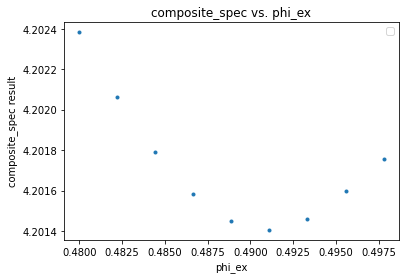

In [350]:
# plt.plot(phi_ex_values, np.array(composite_spec_results1), label='truncated osci_basis')
# plt.plot(phi_ex_values, np.array(composite_spec_results2), label='2nd swt')
# plt.plot(phi_ex_values[:], np.array(composite_spec_results3)[:], label='osc_basis')
plt.plot(phi_ex_values[:], np.array(composite_spec_results4)[:], '.')
# plt.plot(phi_ex_values, np.array(composite_spec_results5), label='analytical')
# plt.ylim(omega_c/2/np.pi,omega_c/2/np.pi+0.025)
plt.xlabel('phi_ex')
plt.ylabel('composite_spec result')
plt.title('composite_spec vs. phi_ex')
plt.legend()
plt.show()